In [1]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np

/home/censky2/miniconda3/envs/mldl/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


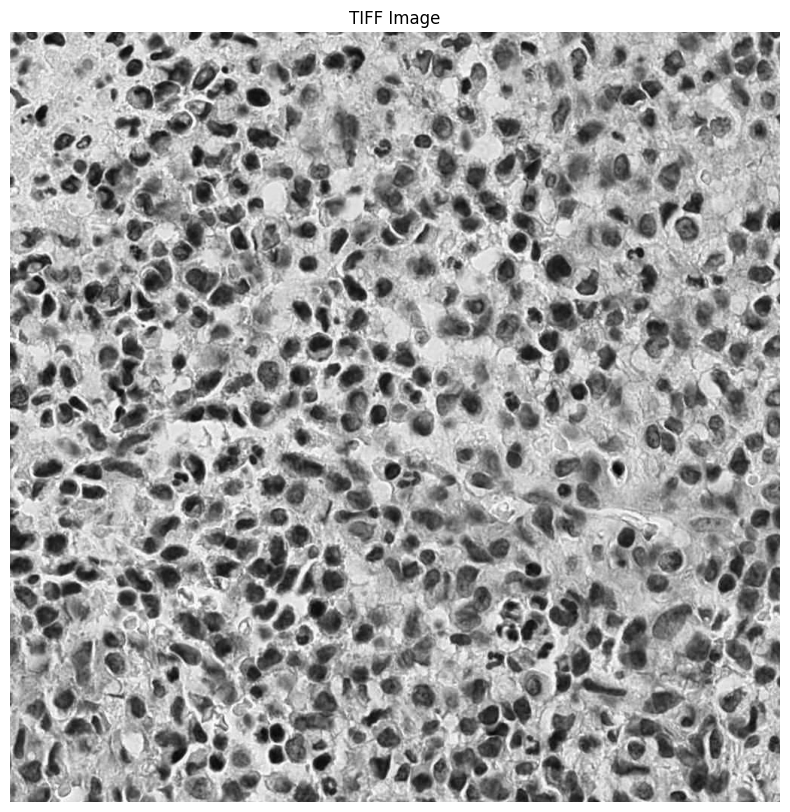

In [2]:
tiff_path = '/home/censky2/MLDLFinal/01_training_dataset_tif_ROIs/01_training_dataset_tif_ROIs/training_set_metastatic_roi_001.tif'

with rasterio.open(tiff_path) as src:
    image = src.read(1) 

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title('TIFF Image')
plt.axis('off')
plt.show()

/tmp/ipykernel_3029589/508311037.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(
/tmp/ipykernel_3029589/508311037.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(
/tmp/ipykernel_3029589/508311037.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(
/tmp/ipykernel_3029589/508311037.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(


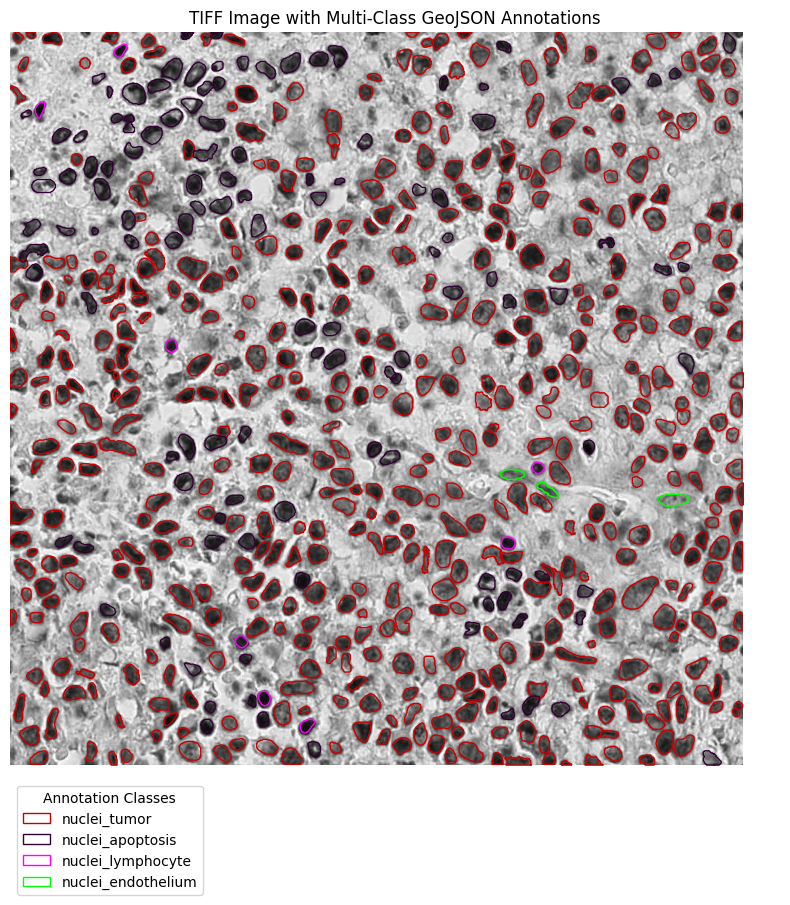

In [3]:
geojson_path = '/home/censky2/MLDLFinal/01_training_dataset_geojson_nuclei/01_training_dataset_geojson_nuclei/training_set_metastatic_roi_001_nuclei.geojson'

annotations = gpd.read_file(geojson_path)

classes = annotations['classification'].unique()

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap='gray')

legend_patches = []

for c in classes:
    res = eval(c)
    color = [v / 255 for v in res['color']]
    subset = annotations[annotations['classification'] == c]
    subset.plot(ax=ax, edgecolor=color, facecolor='none', linewidth=1, aspect=1)

    legend_patches.append(
        mpatches.Patch(
            color=color, 
            label=res['name'], 
            fill=False, 
            edgecolor=color
        )
    )

plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0, -0.05), title='Annotation Classes')
plt.title('TIFF Image with Multi-Class GeoJSON Annotations')
plt.axis('off')
plt.show()